In [2]:
import numpy as np 
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import KFold, GroupKFold

from sklearn.ensemble import VotingRegressor

#import optuna

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
import gc
pd.set_option('display.max_columns', None)
#########################################################
input_dir = 'data/'
train = pd.read_csv(input_dir+'train.csv')

In [379]:
# train = cudf.read_csv('../input/ventilator-pressure-prediction/train.csv')
# exhale = 80-train.groupby('breath_id')[['u_out']].agg('sum')
# length = train.groupby('breath_id')[['time_step']].agg('max')
# print('Train shape:',train.shape)
# train.head()
train = pd.read_pickle(input_dir+'train.pkl')
test = pd.read_pickle(input_dir+'test.pkl')


In [394]:
train.groupby('breath_id')['u_out'].sum().min()


47.0

In [392]:
# train.groupby('breath_id')['u_out'].sum().min()
train['id_1'] = train.id%80
train.loc[train.id_1==0] = 80

In [396]:
tr = train.loc[train['id_1']<=33]

In [400]:
cor = tr.corr()

In [428]:
# abs(cor['pressure']).sort_values(ascending = False)
# tr.columns
# i = 17
# plt.scatter(tr[tr.columns[i]],tr.pressure)
# print(tr.columns[i])
tr['max_vol_reached'] = tr.groupby('breath_id')['sgn_u_in_diff'].apply(lambda x : (x<0).cumsum())

In [432]:
# tr.groupby('breath_id')['max_vol_reached']
# plt.scatter(tr[tr.columns[-1]],tr.pressure)
# tr.columns[-1]
from scipy.stats import pearsonr

In [439]:
pearsonr(tr['time_step'].values,tr['pressure'].values)
# tr['id_1'].max()

(0.37402818111587177, 0.0)

In [328]:
train['u_in_2nd_diff'] = train.groupby('breath_id')['u_in_diff'].diff().fillna(0)

In [50]:
corr = train.corr()

In [54]:
train_log = np.log(train)

In [55]:
corr_log = train_log.fillna(0).corr()

In [63]:
# abs(corr_log['pressure']).sort_values(ascending = False).index
inhale_train = train.loc[train.u_out ==0]
exhale_train = train.loc[train.u_out ==1]


In [68]:
corr_inhale = inhale_train.corr()

In [100]:
# abs(corr_inhale['pressure']).sort_values(ascending = False)
inhale_train = train.loc[train.u_out ==0]
exhale_train = train.loc[train.u_out ==1]

In [78]:
# abs(corr_inhale['pressure']).sort_values(ascending = False)
br_to_remove = inhale_train.loc[(inhale_train['pressure'])<=0,'breath_id']

In [83]:
id_00 = list(set(train.breath_id.unique().tolist())-set(br_to_remove.unique().tolist()))

In [89]:
cor_00 = inhale_train.loc[inhale_train.breath_id.isin(id_00)].corr()

# len(id_00)

NameError: name 'corr_00' is not defined

In [91]:
# abs(cor_00['pressure']).sort_values(asceding = False)

Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'area',
       'cross', 'cross2', 'u_in_cumsum', 'one', 'count', 'u_in_cummean',
       'u_in_diff', 'time_step_diff', 'air_press_lung',
       'air_press_lung_cumsum', 'sgn_u_in_diff', 'ewm_u_in_mean',
       'ewm_u_in_std', 'u_in_lag_back4', 'u_out_lag_back4', 'rolling_10_mean',
       'rolling_10_max', 'rolling_10_std', 'u_in_lag_back2', 'u_out_lag_back2',
       'expand_mean', 'expand_max', 'expand_std', 'u_in_lag_back1',
       'u_out_lag_back1', 'u_in_lag', 'u_in_lag2', 'u_in_lag3', 'u_in_lag4',
       'u_out_lag', 'u_out_lag2', 'u_out_lag3', 'u_out_lag4', 'u_in_2nd_diff',
       'breath_id__u_in__max', 'breath_id__u_out__max',
       'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean', 'u_in_diff3',
       'u_out_diff3', 'u_in_diff4', 'u_out_diff4', 'R_20', 'R_5', 'R_50',
       'C_10', 'C_20', 'C_50', 'RC_2010', 'RC_2020', 'RC_2050', 'RC_5010',
       'RC_5020', 'RC_5050', 'RC_510', 'RC_520', 'RC_550'],
   

In [135]:
# i = 0
# abs(np.log(inhale_train).fillna(0).corr()['pressure']).sort_values(ascending = False)['u_in_2nd_diff']
# import tensorflow as tf
inhale_train['pressure_diff'] = inhale_train.groupby('breath_id')['pressure'].diff().fillna(0)

In [137]:
# tf.__version__
inhale_train['dp_dt'] = inhale_train['pressure_diff']/inhale_train['time_step_diff'].fillna(0)

In [157]:
train_inhale.R.unique() , train_inhale.C.unique() 

(array([20, 50,  5], dtype=int64), array([50, 20, 10], dtype=int64))

<AxesSubplot:xlabel='pressure', ylabel='Density'>

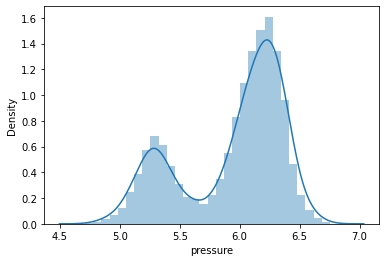

In [162]:
# sns.distplot(inhale_train['dp_dt'])
# abs(inhale_train.loc[train_inhale.id%40 == 2].corr()['pressure']).sort_values(ascending =False)
sns.distplot(inhale_train.loc[(train_inhale.id%80 == 1)& (train_inhale.R == 5)& (train_inhale.C == 50),'pressure'])

In [124]:
# abs(corr['pressure']).sort_values(ascending = False).index
rcs = ['RC_2010', 'RC_2020', 'RC_2050', 'RC_5010',
       'RC_5020', 'RC_5050', 'RC_510', 'RC_520', 'RC_550']
abs(inhale_train.loc[inhale_train[rcs[i]] == 1].corr()['pressure']).sort_values(ascending = False)



IndexError: list index out of range

In [268]:
# from scipy.stats import t, norm 
# sns.distplot(inhale_train.dp_dt,fit = t)
# sns.distplot(inhale_train.air_press_lung,fit = t)
t.fit(inhale_train.dp_dt.values)
# inhale_train.fillna(0,inplace = True)

(1.0, 0.0, 1.0)

<AxesSubplot:xlabel='dp_dt', ylabel='Density'>

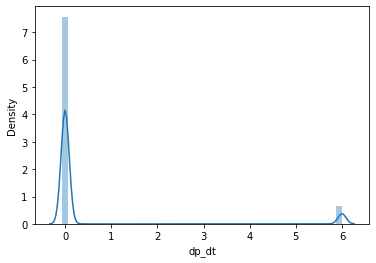

In [289]:
sns.distplot(((inhale_train.dp_dt)**(-5)).clip(upper = 6))

In [249]:
# i+=1
# from scipy.stats import boxcox
# sns.distplot(((inhale_train.dp_dt.astype('float64'))).fillna(0))
# inhale_train.dp_dt.max()
# sns.displot((inhale_train.u_in_diff/inhale_train.dp_dt).clip(-np.inf).fillna(-10000))
a = inhale_train[inhale_train.id.isin(inhale_train.loc[inhale_train.dp_dt<0].groupby('breath_id')['id'].min().values.tolist())].time_step
b = inhale_train[inhale_train.id.isin(inhale_train.loc[inhale_train.u_in_diff<0].groupby('breath_id')['id'].min().values.tolist())].time_step

In [250]:
# from scipy.stats.stats import pearsonr   
# a = [1,4,6]
# b = [1,2,3]   
# print(pearsonr(a,b))
# len(b)
# len(b)/inhale_train.breath_id.unique().shape[0]
# b.index.isin(a.index
a.index = (a.index//80)+1
b.index = (b.index//80)+1

<AxesSubplot:xlabel='time_step', ylabel='Density'>

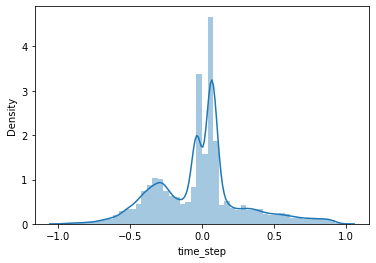

In [266]:
# pearsonr(np.log(a[a.index.isin(b.index)]) , np.log(b[b.index.isin(a.index)]))
sns.distplot(a[a.index.isin(b.index)]-b[b.index.isin(a.index)])
# sns.distplot()


In [17]:
# # exhale.u_out.unique()

# # CONVERT TRAIN TO SERIES
# series = train.groupby('breath_id').collect().reset_index()
# for k in range(80): series[f'x_{k}'] = series.u_in.list.get(k)
# for k in range(80): series[f'y_{k}'] = series.pressure.list.get(k)
# for k in range(80): series[f'z_{k}'] = 1-series.u_out.list.get(k)
# series.R = series.R.list.get(0)
# series.C = series.C.list.get(0)
# series = series.drop(['id','time_step','u_in','u_out','pressure'],axis=1)
# series = series.merge(exhale,on='breath_id',how='left')
# series = series.merge(length,on='breath_id',how='left')
# series = series.rename({'time_step':'time_length','u_out':'expire'},axis=1)
# series = series.sort_values('breath_id').reset_index(drop=True)

# print('Train as series shape:', series.shape )
# print('Min inhale length=', series['expire'].min(),',Max inhale length=', series['expire'].max(),
#       'Max breath length=',series['time_length'].max() )
# series.head()


In [34]:
# sns.distplot(train.pressure)
# train.loc[train.u_out == 0,'time_step' ].max()
train['log_time'] = np.log(train['time_step'])
train.fillna(0,inplace = True)

In [36]:
train.corr()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,log_time
id,1.000000,0.999999,0.001853,0.007222,-0.000199,-0.002380,-0.000089,-0.002402,-0.000124
breath_id,0.999999,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394,-0.000136
R,0.001853,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976,-0.009353
C,0.007222,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727,0.003100
time_step,-0.000199,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829,0.899358
u_in,-0.002380,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136,-0.435356
u_out,-0.000089,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910,0.793884
pressure,-0.002402,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000,-0.389569
log_time,-0.000124,-0.000136,-0.009353,0.003100,0.899358,-0.435356,0.793884,-0.389569,1.000000


In [329]:
# inhale_train['p_times_dt'] = inhale_train['time_step_diff']*inhale_train['pressure']
# train.pivot(index='breath_id', columns='id', values='pressure')
train['id'] = train['id']%80
train.loc[train['id']==0,'id'] = 80

In [332]:
# train
tr = train.pivot(index='breath_id', columns='id', values='pressure')

In [378]:
# plt.plot((tr[1]/tr[2]).sort_values().values)
# plt.plot((tr[2]/tr[3]).sort_values().values)
# plt.plot(((tr[4]-tr[3])/tr[4]).sort_values().values)
# (tr[1]/tr[2]).info()
# sns.distplot((tr[2])/tr[3])
tr.astype('float32').max().max()

64.8125

<AxesSubplot:ylabel='Density'>

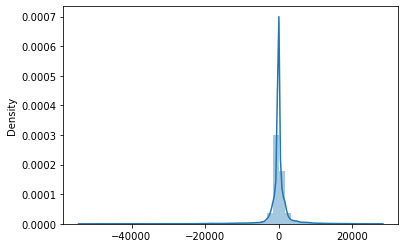

In [320]:
# sns.distplot(inhale_train['p_times_dt']*inhale_train['dp_dt'])
# sns.distplot((inhale_train.groupby('breath_id')['pressure_diff'].diff().fillna(0)/(inhale_train.time_step_diff)**2).fillna(0))

In [37]:
train_inhale = train.loc[train.u_out == 0]
train_exhale = train.loc[train.u_out == 1]

<AxesSubplot:xlabel='dp_dt', ylabel='Density'>

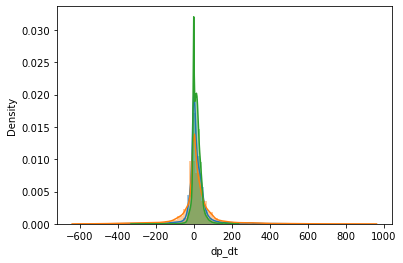

In [303]:
# 
sns.distplot(inhale_train.loc[inhale_train.R_20 == 1,'dp_dt'])
sns.distplot(inhale_train.loc[inhale_train.R_50 == 1,'dp_dt'])
sns.distplot(inhale_train.loc[inhale_train.R_5 == 1,'dp_dt'])

# sns.distplot(inhale_train.loc[inhale_train.RC_2020 == 1,'dp_dt'])


In [299]:
# train_inhale['press_u_in'] = (train_inhale['u_in'])/(train_inhale['pressure']) 
# train_inhale.fillna(0)
inhale_train.columns
# train

Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'area',
       'cross', 'cross2', 'u_in_cumsum', 'one', 'count', 'u_in_cummean',
       'u_in_diff', 'time_step_diff', 'air_press_lung',
       'air_press_lung_cumsum', 'sgn_u_in_diff', 'ewm_u_in_mean',
       'ewm_u_in_std', 'u_in_lag_back4', 'u_out_lag_back4', 'rolling_10_mean',
       'rolling_10_max', 'rolling_10_std', 'u_in_lag_back2', 'u_out_lag_back2',
       'expand_mean', 'expand_max', 'expand_std', 'u_in_lag_back1',
       'u_out_lag_back1', 'u_in_lag', 'u_in_lag2', 'u_in_lag3', 'u_in_lag4',
       'u_out_lag', 'u_out_lag2', 'u_out_lag3', 'u_out_lag4', 'u_in_2nd_diff',
       'breath_id__u_in__max', 'breath_id__u_out__max',
       'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean', 'u_in_diff3',
       'u_out_diff3', 'u_in_diff4', 'u_out_diff4', 'R_20', 'R_5', 'R_50',
       'C_10', 'C_20', 'C_50', 'RC_2010', 'RC_2020', 'RC_2050', 'RC_5010',
       'RC_5020', 'RC_5050', 'RC_510', 'RC_520', 'RC_550', 'pre

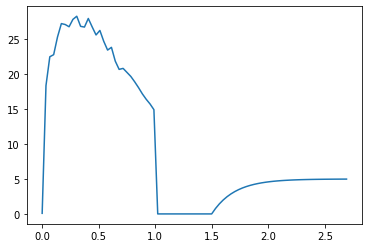

In [31]:
plt.plot(train.groupby('breath_id').get_group(1)['time_step'],train.groupby('breath_id').get_group(1)['u_in'])

In [33]:
train.groupby('breath_id').get_group(1)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,log_time
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.033098
2,3,1,20,50,0.067514,22.509278,0,7.876254,0.065333
3,4,1,20,50,0.101542,22.808822,0,11.742872,0.096711
4,5,1,20,50,0.135756,25.355850,0,12.234987,0.127298
...,...,...,...,...,...,...,...,...,...
75,76,1,20,50,2.553593,4.974474,1,6.399909,1.267959
76,77,1,20,50,2.587754,4.978481,1,6.610815,1.277526
77,78,1,20,50,2.621773,4.981847,1,6.329607,1.286964
78,79,1,20,50,2.655746,4.984683,1,6.540513,1.296300


In [441]:
pd.DataFrame([[0,1],[0,0]])

,0,1
0,0,1
1,0,0
